In [1]:
import numpy as np
import pandas as pd
import pickle
import gc
import matplotlib.pyplot as plt 
from tqdm import tqdm
from loguru import logger
from sklearn import metrics
from source.utils.file_read import process_and_concat_files 
from source.utils.file_read import filter_df
from sklearn.utils.fixes import parse_version, sp_version
solver = "highs" if sp_version >= parse_version("1.6.0") else "interior-point"
from IPython.display import clear_output

In [2]:
from source.ensemble.stack_generalization.ramp_detection.utils_plot import calculate_ramp_events, plot_ramp_confusion_matrix
from source.ensemble.stack_generalization.ramp_detection.lof_detector import detect_wind_ramp_lof
from source.ensemble.stack_generalization.ramp_detection.utils import append_wind_ramps, append_ramp_alarm_days

In [3]:
from config.ramp_calib_setting import Simulation, WeightedAvg, Stack
from source.utils.session_ml_info import delete_previous_day_pickle
sim_params = Simulation.testing_period
weight_avg_params = WeightedAvg.params
ens_params = Stack.params

Testing Days: 100%|██████████| 300/300 [00:34<00:00,  8.74it/s]


Actual ramp events num: 12
Predicted ramp events num: 256
Total dates: 300
Critical Success Index (CSI): 0.04
Bias Score (BS): 23.27
F1 Score: 0.08
ROC AUC: 0.58


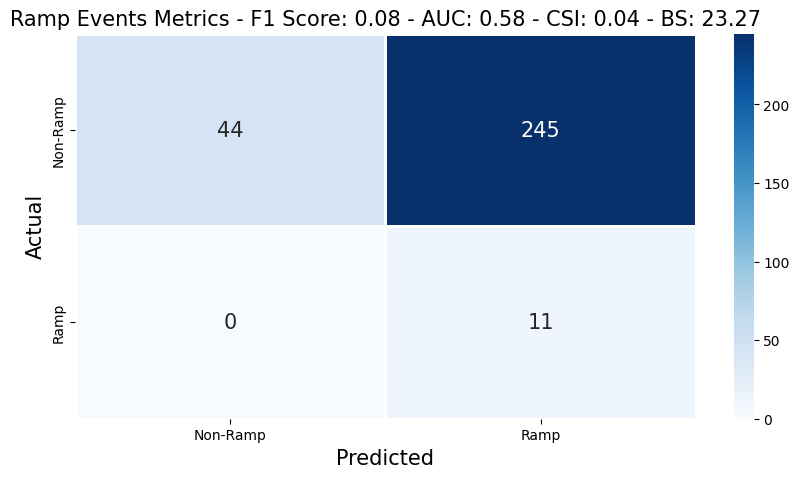

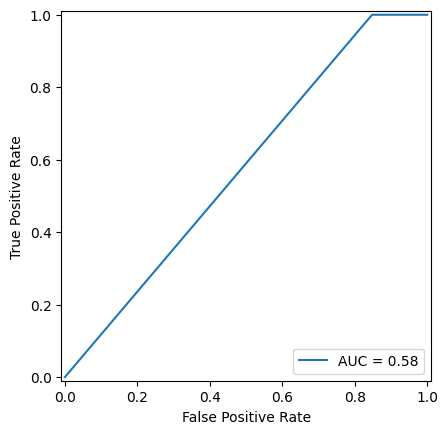

Actual ramp events num: 12
Predicted ramp events num: 414
Total dates: 900
Critical Success Index (CSI): 0.02
Bias Score (BS): 37.64
F1 Score: 0.04
ROC AUC: 0.64


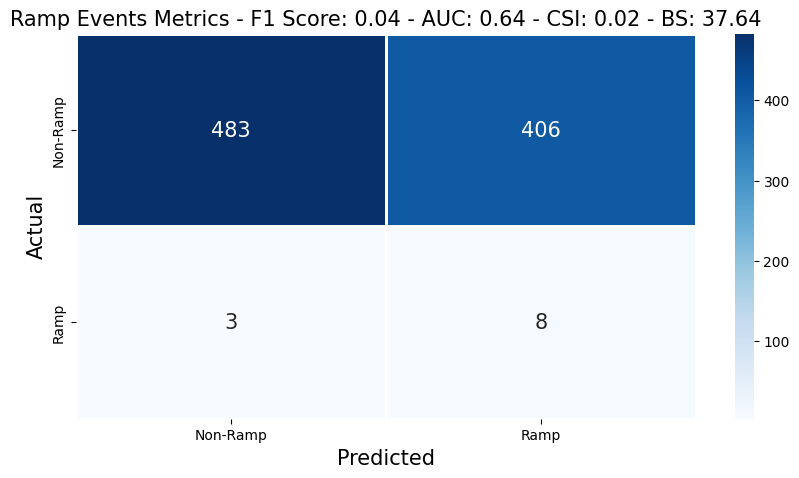

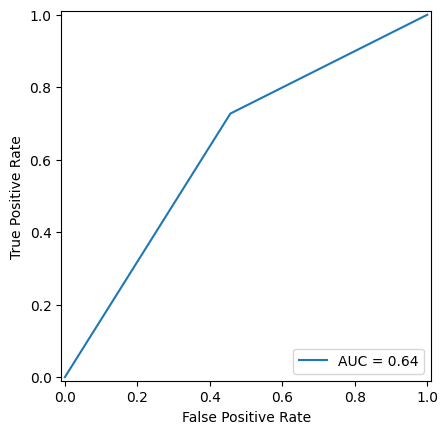

In [4]:
# set random seed
np.random.seed(sim_params['random_seed'])

# process and concatenate files
files = [sim_params['file_1'], sim_params['file_2'], sim_params['file_3'], sim_params['file_4'], 
            sim_params['file_5'], sim_params['file_6'], sim_params['file_7'], sim_params['file_8'], 
            sim_params['file_9'], sim_params['file_10'], sim_params['file_11'], sim_params['file_12']]

logger.info(' ')
logger.info(f'Load Files: {files}')

df = process_and_concat_files(files)

# filter data forecasters
df_filtered = filter_df(df, sim_params['forecasts_col'], sim_params['measured_col'])

# replace NaN values
if sim_params['replace_nan']:
    logger.info(' ')
    logger.warning("Replacing NaN values with 0s")
    print(df_filtered.isna().sum())
    df_filtered.fillna(0, inplace=True)

# set buyer resource name
buyer_resource_name = 'b1r1'

# remove previous day pickle file
logger.info(' ')
delete_previous_day_pickle()
logger.opt(colors = True).warning('previous day pickle file removed')

# loop over max_consecutive_points
for max_consecutive_points in [3]:  # [3, 4, 5, 6, 9]:
    
    # loop over n_neighbors values
    for n_neighbors in [5, 10, 15, 20, 25, 30]: 

        # lists to store f1 and roc auc scores
        list_f1 = []
        list_roc_auc = []
        list_csi = []
        list_bs = []
        
        # loop over contamination values
        for contamination in [0.01, 0.05, 0.075, 0.1, 0.15]:
            
            # loop over preprocess_ramps
            for preprocess_ramps in [True]:

                # Collect Ramp Alarm
                list_ramp_alarm = []
                # Collect Ramp Alarm Intraday
                list_ramp_alarm_intraday = []
                # Days of Ramp Alarm
                list_ramp_alarm_days = []
                # Days of Wind Ramps
                lst_wind_ramps_days = []

                # load pickle file named 'results_lof.pkl'
                with open('/Users/gio/Desktop/Elia-RES-Forecasting/results_lof_no_mostrecent.pkl', 'rb') as f:
                    results_lof = pickle.load(f)

                # loop over test days
                for i in tqdm(range(len(results_lof)), desc='Testing Days'):

                    logger.info(' ')
                    logger.opt(colors = True).info(f'<blue>-------------------------------------------------------------------------------------------</blue>')
                    logger.opt(colors=True).info(f'<blue> Testing Day : {i}</blue>')
                    logger.opt(colors=True).info(f'<blue> n_neighbors : {n_neighbors}</blue>')
                    logger.opt(colors=True).info(f'<blue> contamination : {contamination}</blue>')
                    logger.opt(colors=True).info(f'<blue> Preprocess Ramps : {preprocess_ramps}</blue>')
                    logger.opt(colors = True).info(f'<blue>-------------------------------------------------------------------------------------------</blue>')

                    pred_var_insample = results_lof[i]['pred_var_in']
                    pred_var_outsample = results_lof[i]['pred_var_out']
                    df_train_norm = results_lof[i]['df_train_norm']
                    df_test_norm = results_lof[i]['df_test_norm']
                    target_variability = results_lof[i]['target_variability']
                    forecast_range = results_lof[i]['forecast_range']
                    df_train = results_lof[i]['df_train']

                    # # ----------------------------> RAMPS ALARM <----------------------------

                    # Detect Wind Ramp using LOF
                    list_ramp_alarm, list_ramp_alarm_intraday, alarm_status, df_ramp_clusters = detect_wind_ramp_lof(pred_insample = pred_var_insample, 
                                                                                                                    pred_outsample = pred_var_outsample,
                                                                                                                    df_train_norm = df_train_norm, 
                                                                                                                    df_test_norm = df_test_norm,
                                                                                                                    list_ramp_alarm = list_ramp_alarm,
                                                                                                                    list_ramp_alarm_intraday = list_ramp_alarm_intraday, 
                                                                                                                    df_train = df_train, 
                                                                                                                    n_neighbors = n_neighbors, 
                                                                                                                    contamination = contamination,
                                                                                                                    preprocess_ramps = preprocess_ramps,
                                                                                                                    max_consecutive_points = max_consecutive_points)
                    
                    # Append Wind Ramps Days
                    lst_wind_ramps_days = append_wind_ramps(df, list_ramp_alarm, i, target_variability, lst_wind_ramps_days, pred_var_outsample)

                    # Append Ramps Alarm Days
                    list_ramp_alarm_days = append_ramp_alarm_days(alarm_status, target_variability, pred_var_outsample, df_ramp_clusters, list_ramp_alarm_days)

                    # Clear Variables
                    del pred_var_insample, pred_var_outsample, target_variability, forecast_range, df_train
                    gc.collect()

                    # Clear output
                    clear_output(wait=True)



                # # ----------------------------> PLOT RAMPS ALARM <----------------------------


                # Calculate Ramp Events
                intraday = False
                ramp_events_by_date, ramp_threshold = calculate_ramp_events(df, list_ramp_alarm, list_ramp_alarm_intraday, intraday=intraday)

                # F1-Score and AUC-Score
                f1, roc_auc, csi, bs, fpr, tpr = plot_ramp_confusion_matrix(ramp_events_by_date)
                plt.show()

                # Plotting the ROC Curve
                display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
                display.plot()
                plt.show()

                # Calculate Ramp Events Intraday
                intraday = True
                ramp_events_by_intraday, _ = calculate_ramp_events(df, list_ramp_alarm, list_ramp_alarm_intraday, intraday=intraday)

                # F1-Score and Confusion Matrix
                f1_intraday, roc_auc_intraday, csi_intraday, bs_intraday, fpr_intraday, tpr_intraday = plot_ramp_confusion_matrix(ramp_events_by_intraday)
                plt.show()

                # Plotting the ROC Curve
                display_intraday = metrics.RocCurveDisplay(fpr=fpr_intraday, tpr=tpr_intraday, roc_auc=roc_auc_intraday)
                display_intraday.plot()
                plt.show()

                # Append F1 Score to list
                list_f1.append({ "n_neighbors" : n_neighbors,
                                            "contamination" : contamination,
                                            # day-ahead
                                            "FPR": fpr, 
                                            "TPR": tpr,
                                            "f1" : f1,
                                            'alarms_days': list_ramp_alarm_days,
                                            "ramp_events_by_date":ramp_events_by_date,
                                            # intraday
                                            "FPR_intraday": fpr_intraday,
                                            "TPR_intraday": tpr_intraday,
                                            "f1_intraday" : f1_intraday,
                                            'alarms_days_intraday': list_ramp_alarm_days,
                                            "ramp_events_by_intraday":ramp_events_by_intraday,
                                            # wind ramps
                                            "lst_wind_ramps_days": lst_wind_ramps_days,
                                            'ramp_threshold':ramp_threshold})
                
                # Append ROC AUC Score to list
                list_roc_auc.append({"n_neighbors" : n_neighbors,
                                                "contamination" : contamination,
                                                # day-ahead
                                                "FPR": fpr, 
                                                "TPR": tpr,
                                                "roc_auc" : roc_auc,
                                                'alarms_days': list_ramp_alarm_days,
                                                "ramp_events_by_date":ramp_events_by_date,
                                                # intraday
                                                "FPR_intraday": fpr_intraday,
                                                "TPR_intraday": tpr_intraday,
                                                "roc_auc_intraday" : roc_auc_intraday,
                                                'alarms_days_intraday': list_ramp_alarm_days,
                                                "ramp_events_by_intraday":ramp_events_by_intraday,
                                                # wind ramps
                                                "lst_wind_ramps_days": lst_wind_ramps_days,
                                                'ramp_threshold':ramp_threshold})
                
                # append csi score
                list_csi.append({"n_neighbors" : n_neighbors,
                                "contamination" : contamination,
                                # day-ahead
                                "FPR": fpr, 
                                "TPR": tpr,
                                "csi" : csi,
                                'alarms_days': list_ramp_alarm_days,
                                "ramp_events_by_date":ramp_events_by_date,
                                # intraday
                                "FPR_intraday": fpr_intraday,
                                "TPR_intraday": tpr_intraday,
                                "csi_intraday" : csi_intraday,
                                'alarms_days_intraday': list_ramp_alarm_days,
                                "ramp_events_by_intraday":ramp_events_by_intraday,
                                # wind ramps
                                "lst_wind_ramps_days": lst_wind_ramps_days,
                                'ramp_threshold':ramp_threshold})
                
                # append bs score
                list_bs.append({"n_neighbors" : n_neighbors,
                                "contamination" : contamination,
                                # day-ahead
                                "FPR": fpr, 
                                "TPR": tpr,
                                "bs" : bs,
                                'alarms_days': list_ramp_alarm_days,
                                "ramp_events_by_date":ramp_events_by_date,
                                # intraday
                                "FPR_intraday": fpr_intraday,
                                "TPR_intraday": tpr_intraday,
                                "bs_intraday" : bs_intraday,
                                'alarms_days_intraday': list_ramp_alarm_days,
                                "ramp_events_by_intraday":ramp_events_by_intraday,
                                # wind ramps
                                "lst_wind_ramps_days": lst_wind_ramps_days,
                                'ramp_threshold':ramp_threshold})


                # Clear output
                clear_output(wait=True)

                # import time
                # time.sleep(5)

        # ## ----------------------------> SAVE RESULTS <----------------------------

        if len(list_f1) != 0:
            # save file
            with open(f'results/lof/{max_consecutive_points}_consecutive_no_mostrecent/{max_consecutive_points}_{n_neighbors}_f1_lof.pkl', 'wb') as f:
                pickle.dump(list_f1, f)

        if len(list_roc_auc) != 0:
            # save file
            with open(f'results/lof/{max_consecutive_points}_consecutive_no_mostrecent/{max_consecutive_points}_{n_neighbors}_roc_auc_lof.pkl', 'wb') as f:
                pickle.dump(list_roc_auc, f)

        if len(list_csi) != 0:
            # save file
            with open(f'results/lof/{max_consecutive_points}_consecutive_no_mostrecent/{max_consecutive_points}_{n_neighbors}_csi_lof.pkl', 'wb') as f:
                pickle.dump(list_csi, f)

        if len(list_bs) != 0:
            # save file
            with open(f'results/lof/{max_consecutive_points}_consecutive_no_mostrecent/{max_consecutive_points}_{n_neighbors}_bs_lof.pkl', 'wb') as f:
                pickle.dump(list_bs, f)

